In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump
from raytracer_utils import read_rayfile as read_rayfile_3D
from load_rayfile_2D import load_rayfile as read_rayfile_2D   # (sorry)



from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = 6 #fig_width_pt*inches_per_pt  # width in inches
fig_height = 6 # fig_width*golden_mean*2      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 20,
          'text.fontsize': 16,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)

# --------------- Latex Plot Beautification --------------------------

/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


loading  /shared/users/asousa/WIPP/WIPPv4/rays/3dWIPP_comparison/newray1000.dat


<IPython.core.display.Javascript object>


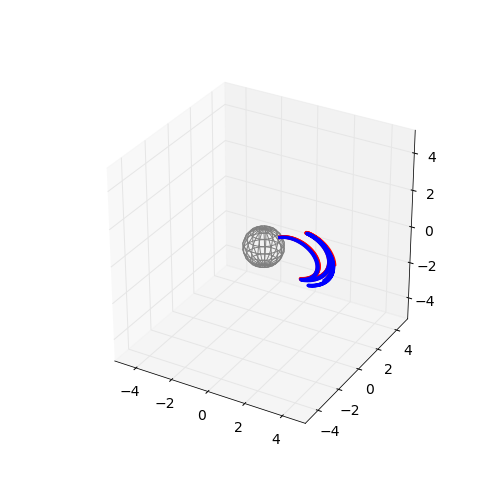

(-5, 5)

In [2]:
# -------------- Load rayfile (3D) ---------------
RF_3d = read_rayfile_3D('/shared/users/asousa/WIPP/3dWIPP/outputs/rayout_ngo_damped.ray')
flashtime = dt.datetime(2010, 6, 4, 3, 17, 0)
R_E = 6371e3 # Radius of earth in meters
D2R = (np.pi/180.0)


psize = 5;

# Convert to geographic coordinates for plotting:
rays_3d = []
for r in RF_3d:
    tmp_coords = coord.Coords(zip(r['pos'].x/(R_E), r['pos'].y/(R_E), r['pos'].z/(R_E)),'SM','car',units=['Re','Re','Re'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords = tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    rays_3d.append(tmp_coords)
    

    
# ------------- Load rayfile (2D) --------------

RF_2d = read_rayfile_2D('/shared/users/asousa/WIPP/WIPPv4/rays/3dWIPP_comparison/', 1000)
lats_2d = np.array(sorted(RF_2d.keys()))

# print RF_2d[RF_2d.keys()[0]].lat
lon = 0
rays_2d = []
for rk in RF_2d.keys():
    r = RF_2d[rk]
    
    X = r.distre*np.cos(r.lat*np.pi/180.0)

    Z = r.distre*np.sin(r.lat*np.pi/180.0)
    
    tmp_coords = coord.Coords(zip(r.distre,r.lat,lon*np.ones_like(r.lat)),'MAG','sph',units=['Re','deg','deg'])
#     tmp_coords = tmp_coords.convert('MAG','car')

#     tmp_coords = coord.Coords(zip(X, Y, Z),'MAG','car',units=['Re','Re','Re'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in np.array(r.tg)]
    
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
#     tmp_coords.sim_time = r.tg
    tmp_coords = tmp_coords.convert('MAG','car')
#     print tmp_coords.units
    rays_2d.append(tmp_coords)
    

# -------- 3D Plot -------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")

# Plot the earth
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
ax.plot_wireframe(x, y, z, color="grey")


# Plot rays:
for r in rays_3d:
    ax.plot(r.x, r.y, r.z, linewidth=3,color='red')

for r in rays_2d:
    ax.plot(r.x, r.y, r.z, linewidth=3,color='blue')
    
ax.set_xlim([-psize, psize])
ax.set_ylim([-psize, psize])
ax.set_zlim([-psize, psize])

In [3]:
# Okay, now compare damping:
# RF_2d.values()[0].power
damp_2d = np.loadtxt('../damping_1000.txt');


fig = plt.figure()
ax = fig.add_subplot(111)


ax.plot(damp_2d[:,0], damp_2d[:,1],'b')
ax.plot(RF_2d.values()[0].tg, RF_2d.values()[0].power,'r')




IOError: [Errno 2] No such file or directory: '../damping_1000.txt'

['qs', 'ms', 'nus', 'pos', 'n', 'stopcond', 'vprel', 'B0', 'damping', 'w', 'time', 'Nspec', 'Ns', 'vgrel']


<IPython.core.display.Javascript object>


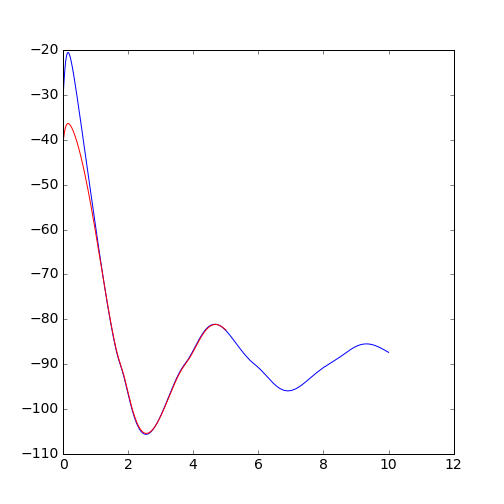

In [4]:
# Compare wavenormal angles between 2d and 3d raytracers:
print RF_3d[0].keys()
psi_2d = RF_2d[40.0].psi
t_2d   = RF_2d[40.0].tg

B_3d = RF_3d[0]['B0']
n_3d = RF_3d[0]['n']
t_3d = RF_3d[0]['time']

psi_3d = np.zeros_like(t_3d)
# print B_3d

for ii in range(0,len(t_3d)):
    b = B_3d.iloc[ii,:]
    n = n_3d.iloc[ii,:]
    
    psi_3d[ii] = (180./np.pi)*np.dot(b,n)/(np.sqrt(np.dot(b,b))*np.sqrt(np.dot(n,n)))
        
plt.figure()
plt.plot(t_2d, psi_2d,'b',t_3d, -90 - psi_3d,'r')

<IPython.core.display.Javascript object>


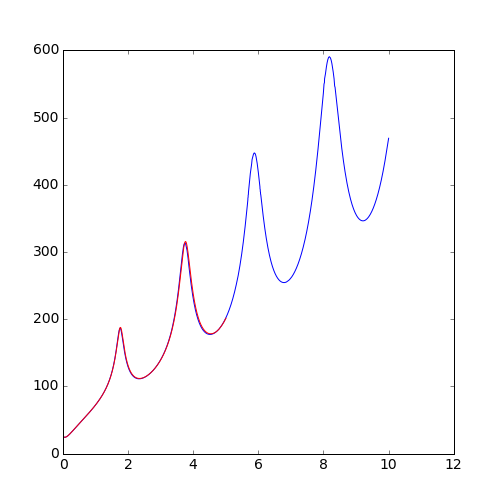

<IPython.core.display.Javascript object>


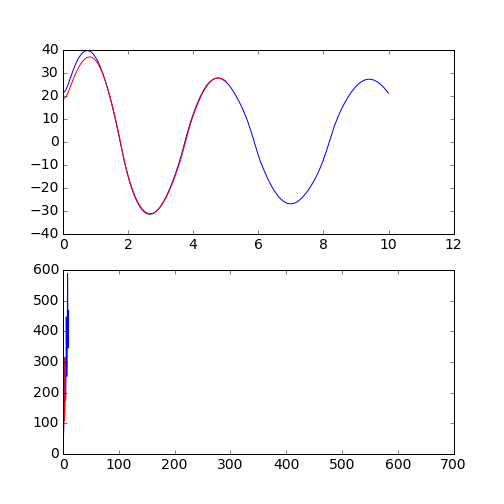

In [5]:
# Compare 2d mu to 3d mag(n)
t_2d   = RF_2d[40.0].tg
mu_2d  = RF_2d[40.0].mu
psi_2d = RF_2d[40.0].psi

t_3d  = RF_3d[0]['time']
mu_3d = np.linalg.norm(RF_3d[0]['n'],axis=1)

plt.figure()
plt.plot(t_2d, mu_2d, 'b', t_3d, mu_3d, 'r')

# Compare nx, nz:
nx_2d = mu_2d*np.abs(np.sin(D2R*psi_2d))
nz_2d = mu_2d*np.cos(D2R*psi_2d)

nz_3d = -np.sin(D2R*psi_3d)*mu_3d
nx_3d = np.cos(D2R*psi_3d)*mu_3d

plt.figure()
plt.subplot(211)
plt.plot(t_2d, nz_2d, 'b', t_3d, nz_3d, 'r')
plt.subplot(212)
plt.plot(t_2d, nx_2d, 'b', t_3d, nx_3d, 'r')

<IPython.core.display.Javascript object>


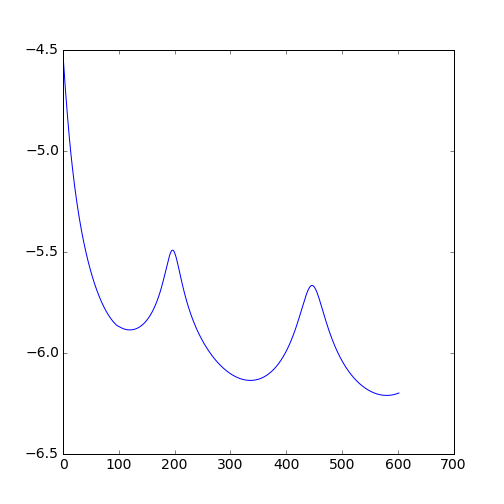

In [10]:
B_3d = RF_3d[0]['B0']
plt.figure()
plt.plot(np.log10(np.linalg.norm(B_3d, axis=1)))

               28            29            30            31
0    6.243257e+09  4.992635e+08  1.248268e+08  5.619166e+09
1    5.555529e+09  5.522389e+08  1.315070e+08  4.871783e+09
2    4.985412e+09  6.057342e+08  1.377362e+08  4.241942e+09
3    4.511534e+09  6.588951e+08  1.434230e+08  3.709216e+09
4    4.116391e+09  7.109013e+08  1.484979e+08  3.256991e+09
5    3.785682e+09  7.610125e+08  1.529158e+08  2.871754e+09
6    3.507683e+09  8.086151e+08  1.566578e+08  2.542410e+09
7    3.272855e+09  8.532317e+08  1.597279e+08  2.259896e+09
8    3.073408e+09  8.945354e+08  1.621499e+08  2.016722e+09
9    2.903009e+09  9.323357e+08  1.639627e+08  1.806711e+09
10   2.756508e+09  9.665634e+08  1.652152e+08  1.624730e+09
11   2.629713e+09  9.972500e+08  1.659622e+08  1.466501e+09
12   2.519223e+09  1.024501e+09  1.662605e+08  1.328462e+09
13   2.422270e+09  1.048474e+09  1.661661e+08  1.207631e+09
14   2.336594e+09  1.069365e+09  1.657322e+08  1.101497e+09
15   2.260817e+09  1.087608e+09  1.65041

<IPython.core.display.Javascript object>


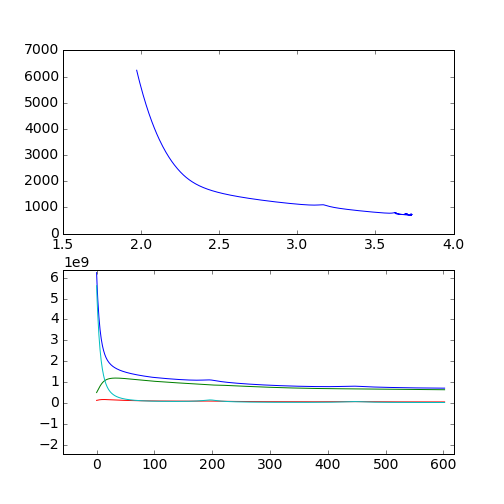

In [35]:
# Compare densities + stix params:
# print RF_2d[40.0].columns

dens_2d = RF_2d[40.0].dens
l_sh_2d = RF_2d[40.0].l_sh

# All species? Hm. First column should be electrons.
dens_3d = np.sum(RF_3d[0]['Ns'],axis=1)/(pow(100,3))
print dens_3d


fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(RF_2d[40.0].l_sh, RF_2d[40.0].dens)


ax2.plot(dens_3d)

['qs', 'ms', 'nus', 'pos', 'n', 'stopcond', 'vprel', 'B0', 'damping', 'w', 'time', 'Nspec', 'Ns', 'vgrel']
Index([u'tg', u'distre', u'lat', u'delta', u'tp', u'l_sh', u'psi', u'psiray',
       u'psires', u'mu', u'dens', u'anH', u'anHe', u'anO', u'fH', u'stixP',
       u'stixR', u'stixL', u'power'],
      dtype='object')


<IPython.core.display.Javascript object>


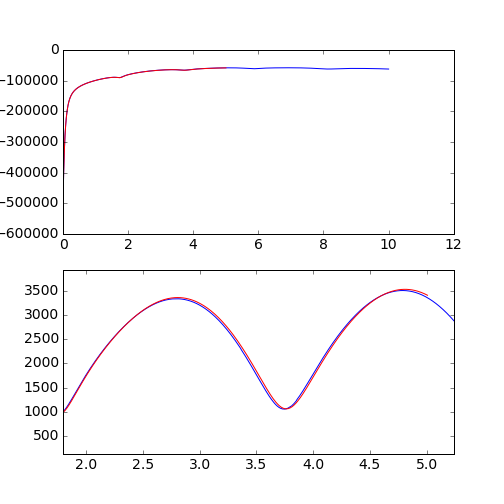

In [99]:
print RF_3d[0].keys()
print RF_2d[40.0].keys()



stixP_2d = RF_2d[40.0].stixP
stixR_2d = RF_2d[40.0].stixR
t_2d   = RF_2d[40.0].tg


t_3d  = RF_3d[0]['time']


Eo = 8.854E-12
w = 2*np.pi*1000.

Ns_3d = RF_3d[0]['Ns']
qs = RF_3d[0]['qs']
ms = RF_3d[0]['ms']
B_3d = np.linalg.norm(RF_3d[0]['B0'],axis=1)
# wps2 = Ns_3d

wps2 = np.multiply(Ns_3d, np.divide(qs*qs, ms*Eo))

whs  = B_3d[:,np.newaxis]*np.divide(qs,ms)



# Stix P:
stixP_3d = 1 - np.sum(wps2,axis=1)/(w*w)

#Stix R:
stixR_3d = 1 - np.sum(np.divide(wps2, w*(w + whs)),axis=1)
fig = plt.figure()
ax1 =fig.add_subplot(211)
ax1.plot(t_2d, stixP_2d, 'b', t_3d, stixP_3d, 'r')

ax2 = fig.add_subplot(212)
ax2.plot(t_2d, stixR_2d, 'b', t_3d, stixR_3d, 'r')
# ax2.plot(t_3d, B_3d)